<a href="https://colab.research.google.com/github/kaisarfardin6620/Shoe_Classifier/blob/main/shoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
import os
import math
import logging
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
tf.get_logger().setLevel('ERROR')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_path = '/content/drive/MyDrive/Dataset/shoes'

In [5]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32
RANDOM_SEED = 42
EPOCHS_STAGE_1 = 100
EPOCHS_STAGE_2 = 200
INITIAL_LR_STAGE_1 = 1e-3
INITIAL_LR_STAGE_2 = 1e-5

In [6]:
def create_dataframe_from_folder(base_dir):
    filepaths = []
    labels = []
    data_sets = []
    image_paths = []

    for data_set in ['train', 'test', 'val']:
        data_set_path = os.path.join(base_dir, data_set)
        if not os.path.isdir(data_set_path):
            logging.warning(f"Directory not found: {data_set_path}. Skipping this split.")
            continue

        logging.info(f"Scanning {data_set_path}...")
        for label_name in os.listdir(data_set_path):
            label_path = os.path.join(data_set_path, label_name)
            if os.path.isdir(label_path):
                for filename in os.listdir(label_path):
                    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                        full_path = os.path.join(label_path, filename)
                        filepaths.append(full_path)
                        labels.append(label_name)
                        data_sets.append(data_set)
                        image_paths.append(full_path)

    if not filepaths:
        logging.error(f"No image files found in {base_dir}. Please check the path and directory structure.")
        return pd.DataFrame()

    df = pd.DataFrame({
        'filepaths': filepaths,
        'label': labels,
        'image_path': image_paths,
        'data set': data_sets
    })
    logging.info(f"DataFrame created with {len(df)} images.")
    return df

In [7]:
df = create_dataframe_from_folder(base_path)

if df.empty:
    print("Exiting: No data found to process. Please check your `base_path` and dataset structure.")
else:
    train_df = df[df['data set'] == 'train'].copy()
    val_df = df[df['data set'] == 'val'].copy()
    test_df = df[df['data set'] == 'test'].copy()

    logging.info(f"Train set size: {len(train_df)}")
    logging.info(f"Validation set size: {len(val_df)}")
    logging.info(f"Test set size: {len(test_df)}")

    NUM_CLASSES = len(train_df['label'].unique())
    logging.info(f"Number of classes detected from DataFrame: {NUM_CLASSES}")

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=RANDOM_SEED,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=RANDOM_SEED,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=RANDOM_SEED,
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
logging.info(f"Class names confirmed from generator: {class_names}")

Found 711 validated image filenames belonging to 3 classes.
Found 143 validated image filenames belonging to 3 classes.
Found 114 validated image filenames belonging to 3 classes.


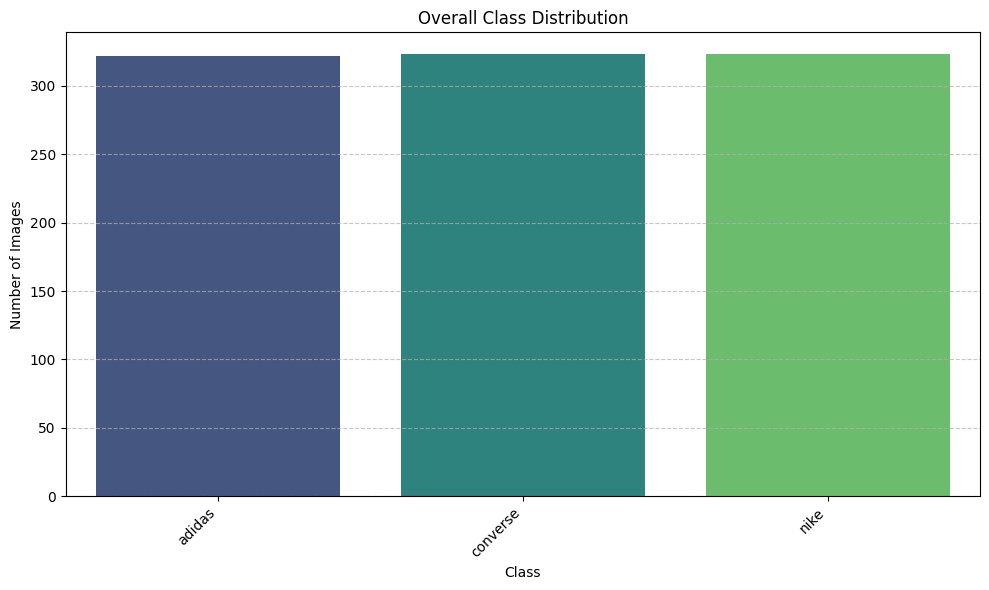

In [9]:
overall_class_distribution = df['label'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=overall_class_distribution.index, y=overall_class_distribution.values,
            hue=overall_class_distribution.index, palette='viridis', legend=False)
plt.title('Overall Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

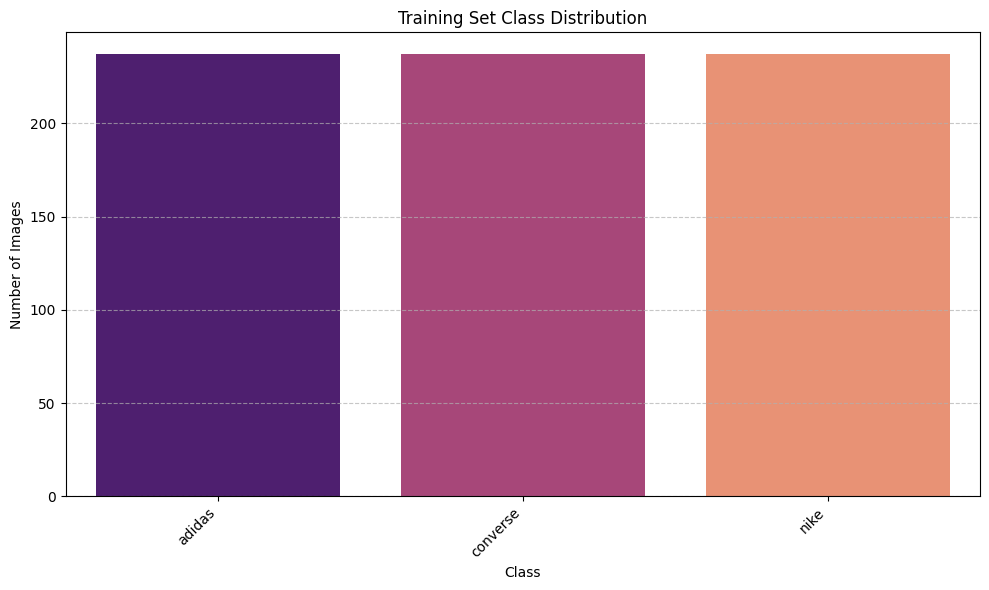

In [10]:
train_class_distribution = train_df['label'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=train_class_distribution.index, y=train_class_distribution.values,
            hue=train_class_distribution.index, palette='magma', legend=False)
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

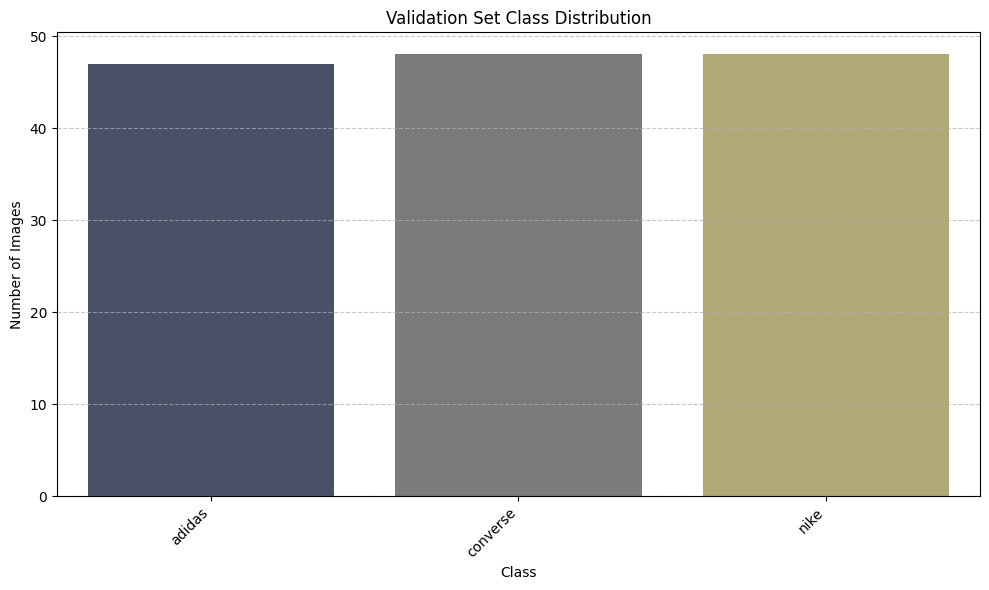

In [11]:
val_class_distribution = val_df['label'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=val_class_distribution.index, y=val_class_distribution.values,
            hue=val_class_distribution.index, palette='cividis', legend=False)
plt.title('Validation Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

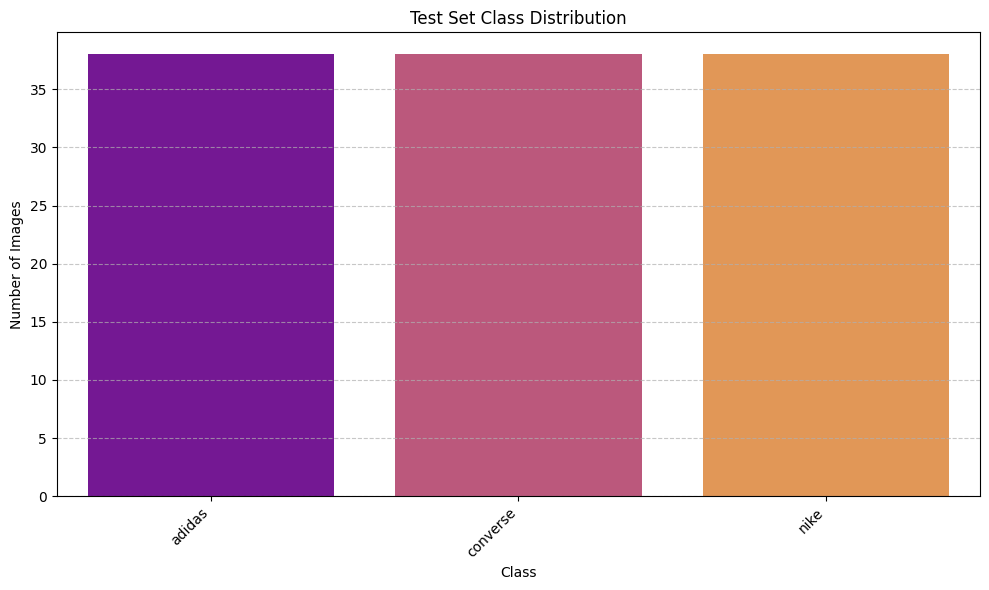

In [12]:
test_class_distribution = test_df['label'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=test_class_distribution.index, y=test_class_distribution.values,
            hue=test_class_distribution.index, palette='plasma', legend=False)
plt.title('Test Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

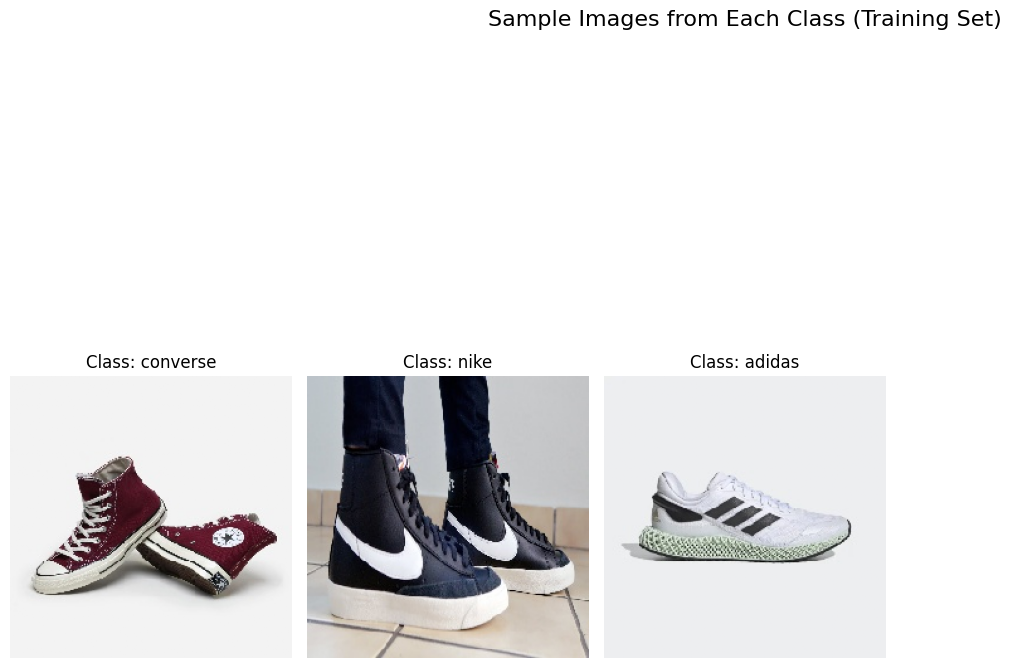

In [13]:
plt.figure(figsize=(15, 10))
unique_labels = train_df['label'].unique()
for i, label in enumerate(unique_labels):
    sample_image_path = train_df[train_df['label'] == label].iloc[0]['filepaths']
    try:
        img = tf.keras.utils.load_img(sample_image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = img_array / 255.0

        plt.subplot(math.ceil(len(unique_labels)/5), 5, i + 1)
        plt.imshow(img_array)
        plt.title(f"Class: {label}")
        plt.axis('off')
    except Exception as e:
        logging.error(f"Could not load image {sample_image_path}: {e}")
        plt.subplot(math.ceil(len(unique_labels)/5), 5, i + 1)
        plt.text(0.5, 0.5, 'Image Load Error', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title(f"Class: {label}")
        plt.axis('off')

plt.suptitle('Sample Images from Each Class (Training Set)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

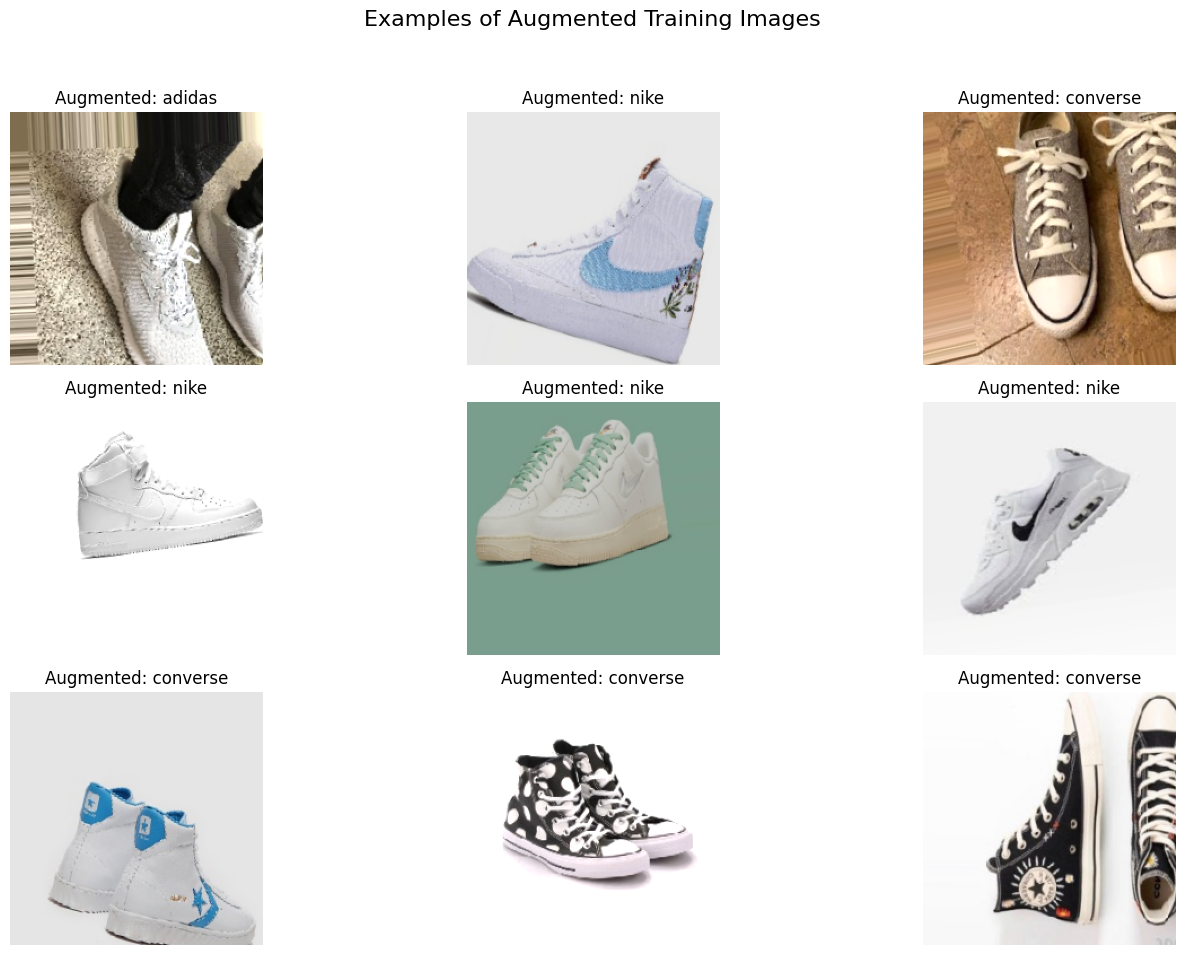

In [14]:

plt.figure(figsize=(15, 10))
for X_batch, y_batch in train_generator:
    for i in range(min(9, BATCH_SIZE)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X_batch[i])
        label_index = np.argmax(y_batch[i])
        class_name = class_names[label_index]
        plt.title(f"Augmented: {class_name}")
        plt.axis('off')
    break

plt.suptitle('Examples of Augmented Training Images', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [15]:
def build_model(num_classes, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

    x = base_model.output

    x = Dense(512, kernel_regularizer=regularizers.l2(0.0001))(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(256, kernel_regularizer=regularizers.l2(0.0001))(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(128, kernel_regularizer=regularizers.l2(0.0001))(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model, base_model

model, base_model = build_model(NUM_CLASSES)

logging.info("Model built successfully.")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,020,067 (87.81 MB)

 Trainable params: 22,983,843 (87.68 MB)

 Non-trainable params: 36,224 (141.50 KB)

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(filepath='shoes_DenseNet121.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=3, min_lr=1e-7, verbose=1)

callbacks_list_stage1 = [early_stopping, reduce_lr, model_checkpoint] #, reduce_lr
callbacks_list_stage2 = [early_stopping, reduce_lr, model_checkpoint] #, reduce_lr

In [18]:
logging.info("Starting Stage 1: Feature Extraction (Freezing base layers)")

for layer in base_model.layers:
    layer.trainable = False

# lr_schedule_stage1 = CosineDecay(
#     initial_learning_rate=INITIAL_LR_STAGE_1,
#     decay_steps=math.ceil(train_generator.samples / BATCH_SIZE) * EPOCHS_STAGE_1
# )
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

logging.info("Model compiled for Stage 1. Base layers are frozen.")

history_stage1 = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / BATCH_SIZE),
    epochs=EPOCHS_STAGE_1,
    validation_data=val_generator,
    validation_steps=math.ceil(val_generator.samples / BATCH_SIZE),
    callbacks=callbacks_list_stage1,
    verbose=1
)

logging.info("Stage 1 training complete.")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3804 - loss: 1.6470
Epoch 1: val_accuracy improved from -inf to 0.51049, saving model to shoes_DenseNet121.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 220s 9s/step - accuracy: 0.3834 - loss: 1.6395 - val_accuracy: 0.5105 - val_loss: 1.1580 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5550 - loss: 1.1551
Epoch 2: val_accuracy improved from 0.51049 to 0.65734, saving model to shoes_DenseNet121.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step - accuracy: 0.5561 - loss: 1.1536 - val_accuracy: 0.6573 - val_loss: 1.0875 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6279 - loss: 1.0462
Epoch 3: val_accuracy did not improve from 0.65734
23/23 ━━━━━━━━━━━━━━━━━━━━ 146s 5s/step - accuracy: 0.6280 - loss: 1.0458 - val_accuracy: 0.6364 - val_loss: 1.0397 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7203 - loss: 0.8924
Epoc

In [19]:
logging.info("Starting Stage 2: Fine-tuning (Unfreezing some base layers)")

for layer in base_model.layers[-20:]:
        layer.trainable = True

# lr_schedule_stage2 = CosineDecay(
#     initial_learning_rate=INITIAL_LR_STAGE_2,
#     decay_steps=math.ceil(train_generator.samples / BATCH_SIZE) * EPOCHS_STAGE_2
# )
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

logging.info("Model re-compiled for Stage 2. Some base layers are unfrozen.")

history_stage2 = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / BATCH_SIZE),
    epochs=EPOCHS_STAGE_2,
    validation_data=val_generator,
    validation_steps=math.ceil(val_generator.samples / BATCH_SIZE),
    callbacks=callbacks_list_stage2,
    verbose=1
)

logging.info("Stage 2 training complete.")

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7467 - loss: 0.8189
Epoch 1: val_accuracy did not improve from 0.93706
23/23 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - accuracy: 0.7454 - loss: 0.8216 - val_accuracy: 0.7902 - val_loss: 0.8895 - learning_rate: 0.0010
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8140 - loss: 0.6004
Epoch 2: val_accuracy did not improve from 0.93706
23/23 ━━━━━━━━━━━━━━━━━━━━ 136s 5s/step - accuracy: 0.8142 - loss: 0.6008 - val_accuracy: 0.9161 - val_loss: 0.3935 - learning_rate: 0.0010
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8334 - loss: 0.5477
Epoch 3: val_accuracy improved from 0.93706 to 0.95105, saving model to shoes_DenseNet121.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - accuracy: 0.8338 - loss: 0.5469 - val_accuracy: 0.9510 - val_loss: 0.2970 - learning_rate: 0.0010
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8847 - loss: 0.4382
Epoch 4: val_accuracy did not improve from 0.9

In [20]:
def combine_histories(h1, h2):
    combined_history = {}
    for key in h1.history.keys():
        combined_history[key] = h1.history[key] + h2.history[key]
    return combined_history

combined_history = combine_histories(history_stage1, history_stage2)

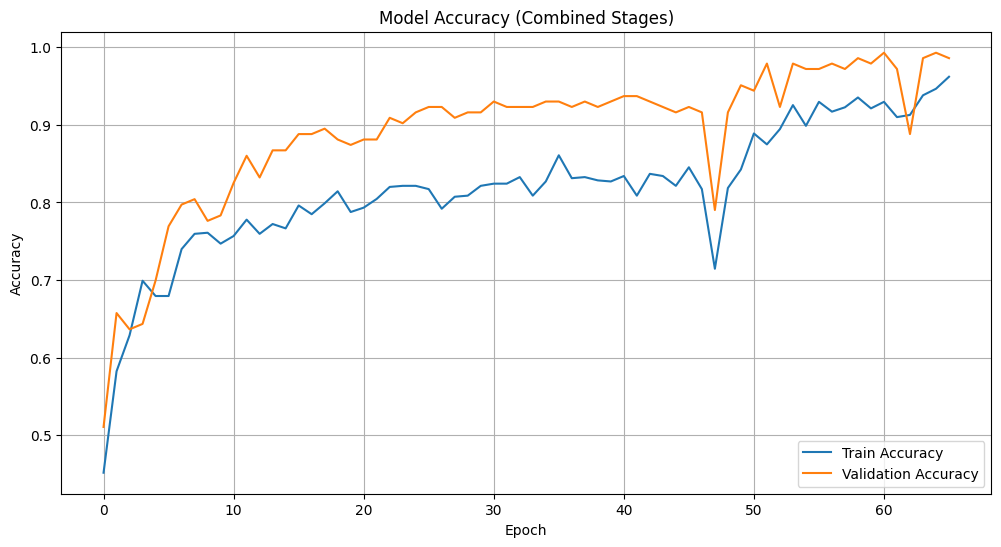

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(combined_history['accuracy'], label='Train Accuracy')
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Combined Stages)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

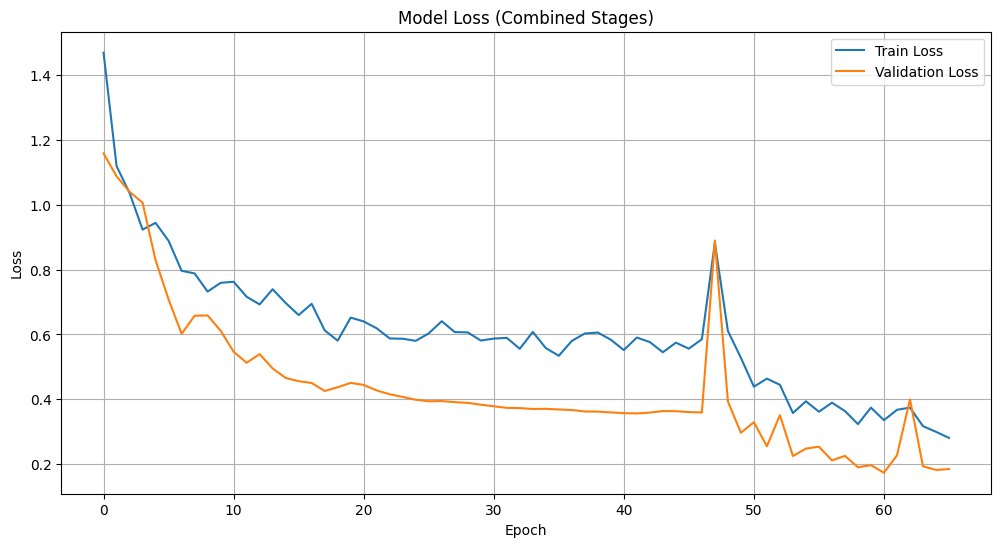

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(combined_history['loss'], label='Train Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Combined Stages)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [23]:
logging.info("Evaluating model on the test set...")
test_loss, test_accuracy = model.evaluate(test_generator, steps=math.ceil(test_df.shape[0] / BATCH_SIZE), verbose=1)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.7776 - loss: 0.9679

Test Loss: 0.8746
Test Accuracy: 0.7982


4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step


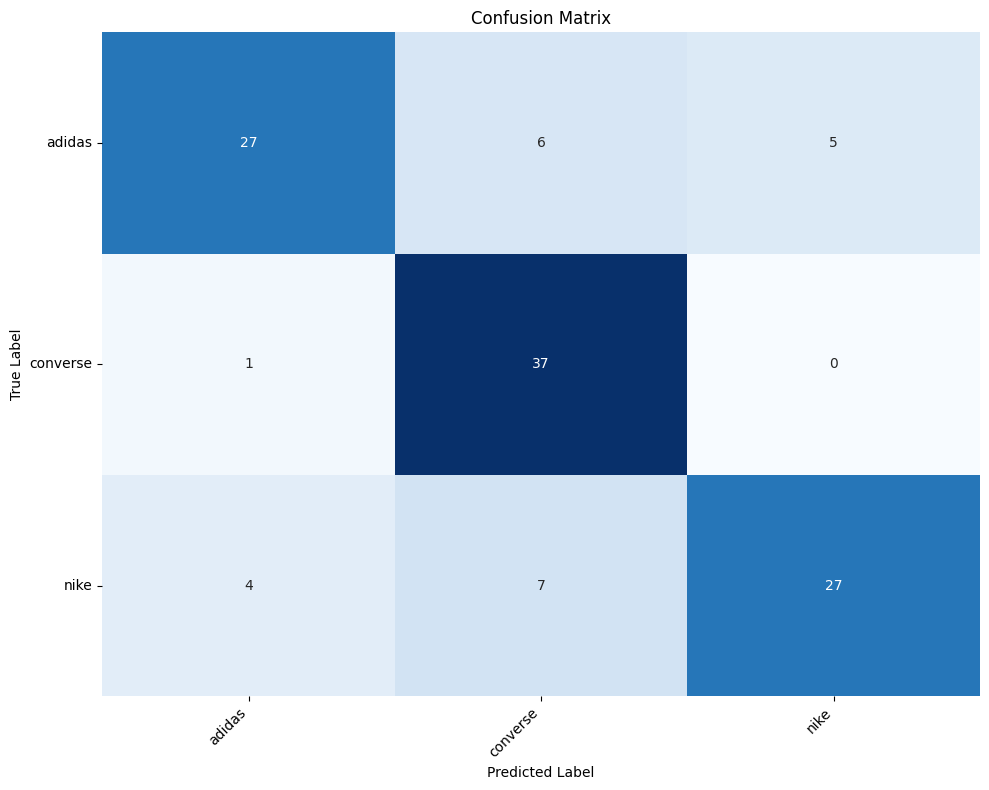

In [24]:
logging.info("Generating predictions for Confusion Matrix...")

y_true = test_generator.classes

y_pred_probs = model.predict(test_generator, steps=math.ceil(test_df.shape[0] / BATCH_SIZE), verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [25]:
logging.info("Generating Classification Report...")
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

      adidas       0.84      0.71      0.77        38
    converse       0.74      0.97      0.84        38
        nike       0.84      0.71      0.77        38

    accuracy                           0.80       114
   macro avg       0.81      0.80      0.79       114
weighted avg       0.81      0.80      0.79       114



1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


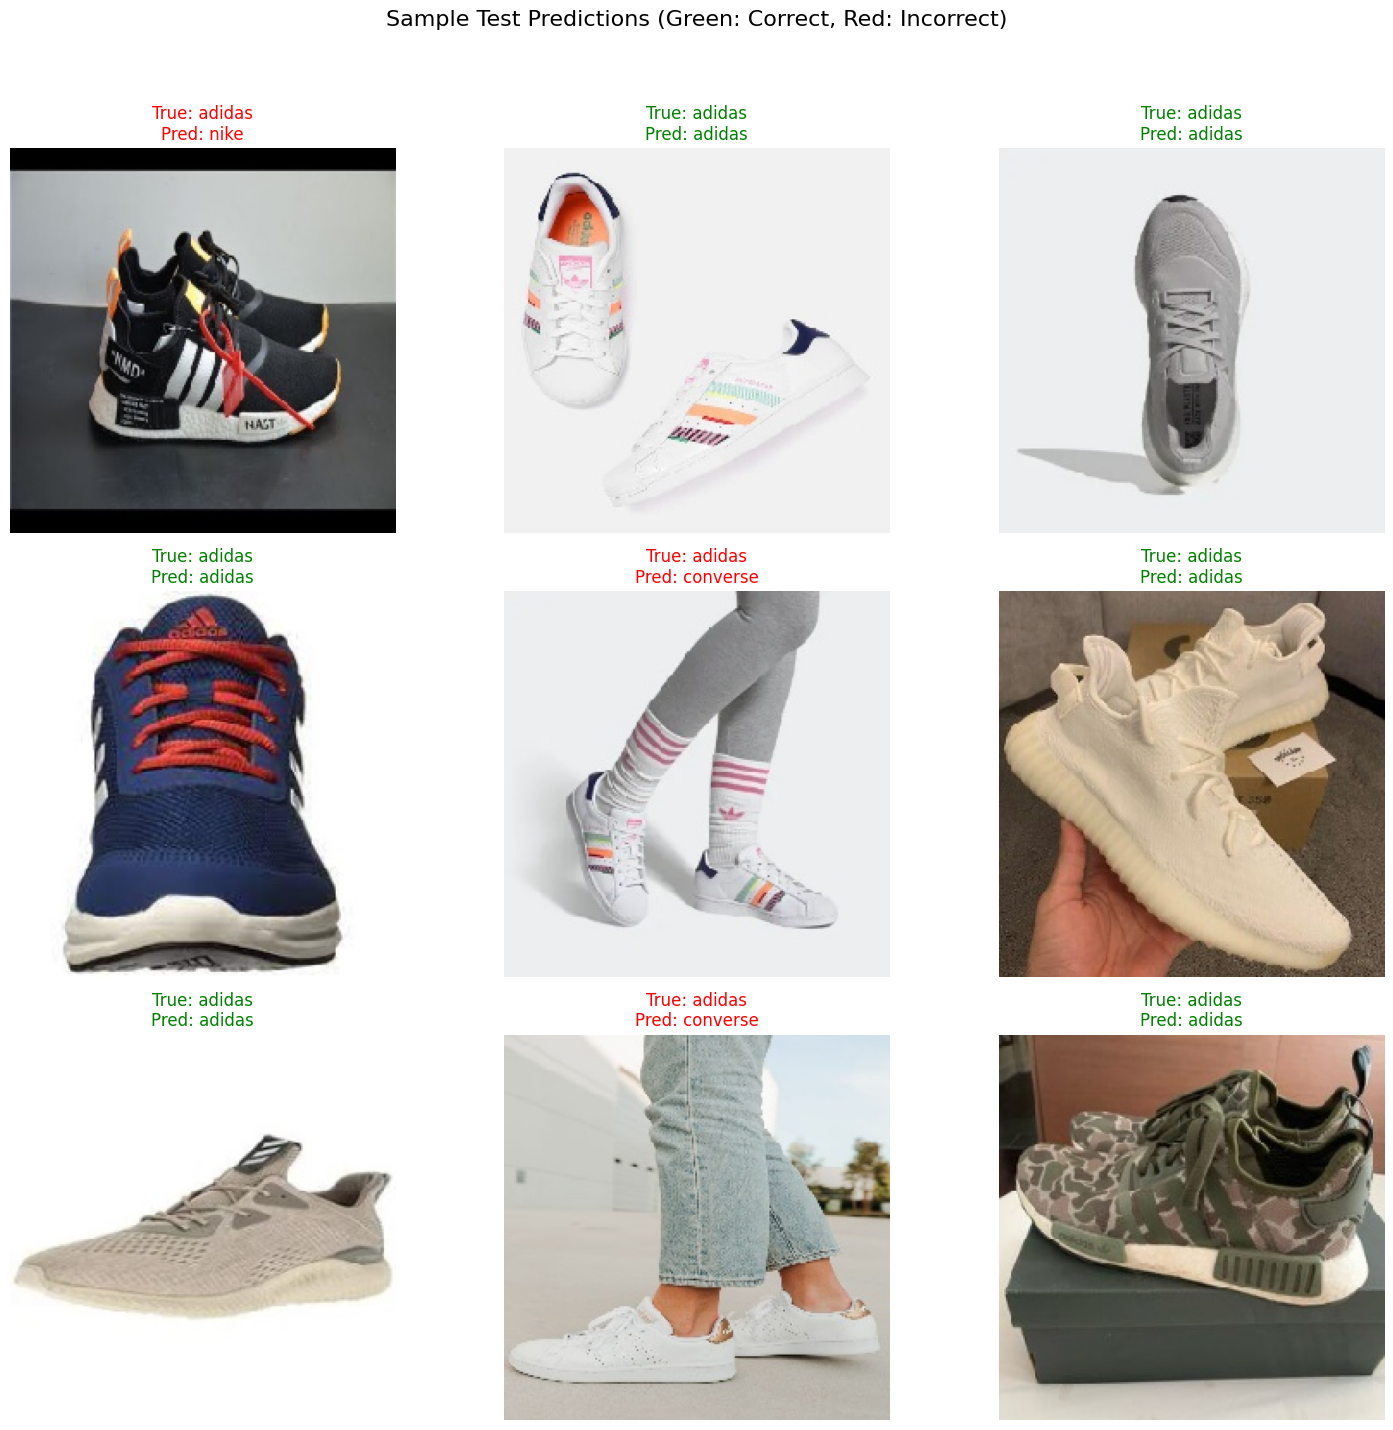

In [26]:
logging.info("Visualizing sample predictions...")

test_images, test_labels_one_hot = next(test_generator)
test_labels_true_indices = np.argmax(test_labels_one_hot, axis=1)

predictions_probs = model.predict(test_images)
predictions_indices = np.argmax(predictions_probs, axis=1)

plt.figure(figsize=(15, 15))
for i in range(min(9, BATCH_SIZE)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i])
    true_label = class_names[test_labels_true_indices[i]]
    predicted_label = class_names[predictions_indices[i]]

    color = "green" if true_label == predicted_label else "red"
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
    plt.axis('off')

plt.suptitle('Sample Test Predictions (Green: Correct, Red: Incorrect)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()